In [1]:
from pylab import *
import pandas as pd
from timeit import default_timer as timer
from HGCal_ImageAlgo3D_kernel_opencl import *

lsz,context,prg = openclkernel(DeviceID=0)
queue = cl.CommandQueue(context)
# For deviceid:
# 0 ...... Intel-Core-i7 CPU: 0001 WI/WG
# 1 ...... Intel-IrisPro GPU: 0512 WI/WG
# 2 ...... NVidia-GT750M GPU: 1024 WI/WG
demoevent = "id>=11 & id<=20  "
#demoevent = "id==1"
DatasetDir  = '/Users/zihengchen/Documents/HGCal/workplace/data/'
DatasetFile = 'CMSSW93X_pt35_pu000'
#DatasetFile = 'CMSSW9304_partGun_PDGid22_x1000_E300.0To300.0_NTUP'

In [2]:
df = pd.read_pickle(DatasetDir+"input/"+DatasetFile+"_rechit.pkl")
dfgen = pd.read_pickle(DatasetDir+"input/"+DatasetFile+"_gen.pkl")

In [3]:
MAXDISTANCE        = np.float32(200)  #cm
LAYER_DISTANCE     = np.float32(0.5)  #cm
KERNAL_R           = np.float32(6.0)  #cm
KERNAL_R_NORM      = np.float32(4.0)  #cm
KERNAL_R_POWER     = np.float32(1.0)  #cm
KERNAL_LAYER       = np.float32(3.0)  #number of layer
DECISION_RHO_KAPPA = np.float32(12.0) #fractio of max rho
DECISION_NHD       = np.float32(4.0)  #cm
CONTINUITY_NHD     = np.float32(6.0)  #cm 

KERNAL_Z           = KERNAL_LAYER*LAYER_DISTANCE

# 0.Load Events

In [4]:
dfevt = df.query(demoevent)
dfevt = dfevt.reset_index(drop=True)

x = np.array(dfevt.x).astype(np.float32)
y = np.array(dfevt.y).astype(np.float32)
z = (np.array(dfevt.z) * LAYER_DISTANCE).astype(np.float32)
e = np.array(dfevt.energy).astype(np.float32)

N = np.int32(e.size)

# 1. Find rho and NearestHigher

In [5]:

LOCALSIZE = int(lsz)
GLOBALSIZE= (int(N/LOCALSIZE)+1)*LOCALSIZE

rho     = np.zeros(N).astype(np.float32)
rhorank = np.zeros(N).astype(np.int32)
nh      = np.zeros(N).astype(np.int32)
nhd     = np.zeros(N).astype(np.float32)

start = timer()
mem_flags = cl.mem_flags
d_x = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf=x)
d_y = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf=y)
d_z = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf=z)
d_e = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf=e)
d_rho     = cl.Buffer(context, mem_flags.READ_WRITE, rho.nbytes)
d_rhorank = cl.Buffer(context, mem_flags.READ_WRITE, rhorank.nbytes)
d_nh      = cl.Buffer(context, mem_flags.READ_WRITE, nh.nbytes)
d_nhd     = cl.Buffer(context, mem_flags.READ_WRITE, nhd.nbytes)

prg.rho_opencl(queue, (GLOBALSIZE,), (LOCALSIZE,),
               d_rho,
               d_x, d_y, d_z, d_e,
               N, KERNAL_R, KERNAL_R_NORM, KERNAL_R_POWER, KERNAL_Z
              )

prg.rhoranknh_opencl(queue, (GLOBALSIZE,), (LOCALSIZE,),
              d_rhorank,d_nh,d_nhd,
              d_x,d_y,d_z,d_rho,
              N, MAXDISTANCE
             )


cl.enqueue_copy(queue, rho, d_rho)
cl.enqueue_copy(queue, rhorank, d_rhorank)
cl.enqueue_copy(queue, nh, d_nh)
cl.enqueue_copy(queue, nhd, d_nhd)

end = timer()
print("number of rechits: {}".format(N))
print("time: {:3.6} ms".format(1000*(end - start)))

number of rechits: 6429
time: 72.3361 ms


# 2. Asign Clusters

In [6]:
cluster = -np.ones(N,int)
DECISION_RHO = rho.max()/DECISION_RHO_KAPPA

# 2.1 convert rhorank to argsortrho 0(N)
argsortrho = np.zeros(N,int)
argsortrho[rhorank] = np.arange(N)

# 2.2 find seeds
selectseed = (rho>DECISION_RHO) & (nhd>DECISION_NHD)
seedrho = rho[selectseed]
temp = seedrho.argsort()[::-1]
seedid = np.empty(len(seedrho), int)
seedid[temp] = np.arange(len(seedrho))
cluster[selectseed] = seedid


# 2.3 asign clusters to seeds
for ith in range(N):
    i = argsortrho[ith]
    if  (cluster[i]<0) & (nhd[i]<CONTINUITY_NHD):
        cluster[i] = cluster[nh[i]]

In [7]:
dfevt['rho']     = pd.Series(rho,        index=dfevt.index)
dfevt['rhorank'] = pd.Series(rhorank,    index=dfevt.index)
dfevt['nh']      = pd.Series(nh,         index=dfevt.index)
dfevt['nhd']     = pd.Series(nhd,        index=dfevt.index)
dfevt['isseed']  = pd.Series(selectseed, index=dfevt.index)
dfevt['cluster'] = pd.Series(cluster,    index=dfevt.index)

In [8]:
########################################
##        END of image algorithm      ##
##             output result          ##
########################################
        
ievent = dfevt.id[0]

clustx,clusty,clustz,clustenergy = [],[],[],[]
for seed in seedid:
    sel = (cluster == seed)
    seedenergy = np.sum(dfevt.energy[sel])
    seedx = np.sum(dfevt.energy[sel]*dfevt.ox[sel])/seedenergy
    seedy = np.sum(dfevt.energy[sel]*dfevt.oy[sel])/seedenergy
    seedz = np.sum(dfevt.energy[sel]*dfevt.oz[sel])/seedenergy
            
    clustenergy.append(seedenergy)
    clustx.append(seedx)
    clusty.append(seedy)
    clustz.append(seedz)
clustenergy = np.array(clustenergy)
clustx = np.array(clustx)
clusty = np.array(clusty)
clustz = np.array(clustz)
clust_inputenergy    = np.sum(dfevt.energy)
clust_includedenergy = np.sum(clustenergy)

dfclus = pd.DataFrame({"id"  :[ievent],
                       "clust_n":[len(clustx)],
                       "clust_x":[clustx],
                       "clust_y":[clusty],
                       "clust_z":[clustz],
                       "clust_energy":[clustenergy],
                       "clust_inputenergy":[clust_inputenergy],
                       "clust_includedenergy":[clust_includedenergy]})

# Done! make validation plots

### Decision Plot

In [9]:
%matplotlib inline
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

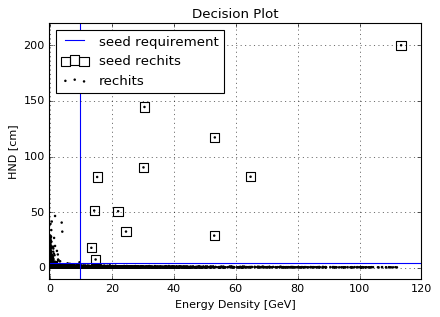

In [10]:
plt.scatter(rho[selectseed], nhd[selectseed],marker='s',
            s=70,edgecolor="k",color="None",label="seed rechits")
plt.scatter(rho, nhd,marker='.',edgecolor="None",color="k",label="rechits")
plt.axvline(DECISION_RHO,color="b",label="seed requirement")
plt.axhline(DECISION_NHD,color="b")

plt.xlabel("Energy Density [GeV]")
plt.ylabel("HND [cm]")
plt.legend(loc="upper left",fontsize=12)
plt.xlim(-0.3)
plt.ylim(-10,220)
plt.grid(True)
plt.title("Decision Plot",fontsize=12)

plt.savefig("../../plot/decision_opencl.png")

### Plotly EventDisplay

In [11]:
gen = dfgen.query(demoevent)

In [12]:
n = len(gen)
genx = np.zeros(n*2)
geny = np.zeros(n*2)
genz = np.zeros(n*2)
for i in range(n):
    genx[2*i]=np.array(gen.gx)[i]
    geny[2*i]=np.array(gen.gy)[i]
    genz[2*i]=np.array(gen.gz)[i]

In [20]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
init_notebook_mode(connected=True)

dfevt = dfevt.reset_index(drop=True)

# 1. clusterred rechits
tempdf = dfevt.query('cluster>-1')
tempx,tempy,tempz,tempe,tempclst = tempdf.ox,tempdf.oy,tempdf.oz,tempdf.energy,tempdf.cluster.max()-tempdf.cluster
rechits = go.Scatter3d(x=tempx,y=tempz,z=tempy,
                       mode='markers',
                       marker=dict(size=14*tempe**0.5,color=tempclst,colorscale='Jet',cmax=tempclst.max(),cmin=0,opacity=0.7,
                                   line = dict(width = 0))) 

# 2. noise rechits
tempdf = dfevt.query('(cluster==-1) & (energy>0.02)')

tempx,tempy,tempz,tempe,tempclst = tempdf.ox,tempdf.oy,tempdf.oz,tempdf.energy,-1
noise   = go.Scatter3d(x=tempx,y=tempz,z=tempy,
                       mode='markers',
                       marker=dict(size=2,color="gray",opacity=1,
                                   line = dict(width = 0))) 
# 3. clusters
tempx,tempy,tempz,tempe = dfclus.clust_x[0],dfclus.clust_y[0],dfclus.clust_z[0],dfclus.clust_energy[0]
cluster = go.Scatter3d(x=tempx,y=tempz,z=tempy,
                       mode='markers',
                       marker=dict(size=5*tempe**0.5,color="gray",opacity=0.8,symbol="square",
                                   line = dict(width = 2, color="black"))) 

# 4. gen particle
genpart = go.Scatter3d(x=genx,
                       y=genz,
                       z=geny,
                       mode='lines',marker=dict(size=0,color="black",opacity=1)) 

x,y,z = geom(1.48,3.0,320,352)
geomEE = go.Surface(x=x, y=z, z=y, surfacecolor=0.5*np.ones_like(y),cmin=0,cmax=1,opacity=0.3)
x,y,z = geom(1.48,3.0,357,410)
geomFH = go.Surface(x=x, y=z, z=y, surfacecolor=0.5*np.ones_like(y),cmin=0,cmax=1,opacity=0.3)
x,y,z = geom(1.4,3.0,415,500)
geomBH = go.Surface(x=x, y=z, z=y, surfacecolor=0.5*np.ones_like(y),cmin=0,cmax=1,opacity=0.3)


data = [geomEE,geomFH,geomBH,rechits,noise,cluster,genpart]
layout = go.Layout(scene=dict(xaxis=dict(title='x (cm)'), yaxis=dict(title='z (cm)'), zaxis=dict(title='y (cm)')),
                   margin=dict(l=0,r=0,b=0,t=0))

fig = go.Figure(data=data, layout=layout)
plot(fig, filename='TEST')

/Users/zihengchen/anaconda/lib/python3.6/site-packages/plotly/offline/offline.py:459: UserWarning:

Your filename `TEST` didn't end with .html. Adding .html to the end of your file.



'file:///Users/zihengchen/Documents/HGCal/workplace/notebooks/demo/TEST.html'

In [14]:
def geom(eta0,eta1,z0,z1):
    R,r = 200,400
    theta0 = 2*np.arctan(np.exp(-eta0))
    theta1 = 2*np.arctan(np.exp(-eta1))
        
    phi = np.linspace(0, 2 * np.pi, 240)
    rad = np.linspace(0, 2 * np.pi, 240)
    phi, rad = np.meshgrid(phi,rad)
    
    z   = ((z0+z1)/2 + r*np.sin(rad)).clip(z0,z1)
    rho = (R+r*np.cos(rad))
    
    for i in range(240):
        for j in range(240):
            rhomax = z[i,j]*np.tan(theta0)
            rhomin = z[i,j]*np.tan(theta1)
            if rho[i,j] > rhomax:
                rho[i,j] = rhomax
            if rho[i,j] < rhomin:
                rho[i,j] = rhomin
    rho = rho.clip(0,250)
                
    x = rho*np.cos(phi) 
    y = rho*np.sin(phi) 
    
    return x,y,z

In [93]:
x,y,z = geom(1.4,3,320,500)
surface = go.Surface(x=x, y=z, z=y)
data = [surface]

layout = go.Layout(scene=dict(xaxis=dict(title='x (cm)'), yaxis=dict(title='z (cm)'), zaxis=dict(title='y (cm)')),
                   margin=dict(l=0,r=0,b=0,t=0),)

fig = go.Figure(data=data, layout=layout)
plot(fig, filename='Parametric_plot')


/Users/zihengchen/anaconda/lib/python3.6/site-packages/plotly/offline/offline.py:459: UserWarning:

Your filename `Parametric_plot` didn't end with .html. Adding .html to the end of your file.



'file:///Users/zihengchen/Documents/HGCal/workplace/notebooks/demo/Parametric_plot.html'

In [61]:
inf >10

True

In [86]:
for i in range(240):
    for j in range(240):
        tempz = z[i,j]
        rhomax = tempz*np.tan(theta0)
        rhomin = tempz*np.tan(theta1)
        if rho[i,j] > rhomax:
            rho[i,j] = rhomax
        if rho[i,j] < rhomin:
            rho[i,j] = rhomin
            
        

array([[ 400.        ,  400.        ,  400.        , ...,  400.        ,
         400.        ,  400.        ],
       [ 405.25729002,  405.25729002,  405.25729002, ...,  405.25729002,
         405.25729002,  405.25729002],
       [ 410.51094675,  410.51094675,  410.51094675, ...,  410.51094675,
         410.51094675,  410.51094675],
       ..., 
       [ 389.48905325,  389.48905325,  389.48905325, ...,  389.48905325,
         389.48905325,  389.48905325],
       [ 394.74270998,  394.74270998,  394.74270998, ...,  394.74270998,
         394.74270998,  394.74270998],
       [ 400.        ,  400.        ,  400.        , ...,  400.        ,
         400.        ,  400.        ]])